In [4]:
import sys
from generate_features import generate_features
import pandas as pd
import matplotlib.pyplot as plt
!{sys.executable} -m pip install statsmodels
## Import statistical package for Vector ARIMA
from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.statespace.tools import diff

import numpy as np


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: C:\Users\danne\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### Import the Datasets

In [5]:
dataset_paths = ["./USDCHF=X.csv", "./Gold_USD.csv", "./SP500.csv", "./SMI.csv"]
dataset_names = [path.split("./")[-1].split(".")[0] for path in dataset_paths]
# Remove =X from the name of USDCHF dataset
dataset_names[0] = dataset_names[0].split("=")[0]
datasets = {}
## Read in the datasets
for ds_name, ds_path in zip(dataset_names, dataset_paths):
    entire_dataset = pd.read_csv(ds_path, parse_dates=['Date'])
    # Drop all but the date and close columns
    datasets[ds_name] = entire_dataset[['Date', 'Close']]
print(dataset_names)

['USDCHF', 'Gold_USD', 'SP500', 'SMI']


### Join the Datasets

In [6]:
# Perform inner join to add the closing price for each dataset into a single df
merged_dataset = datasets[dataset_names[0]]
for ds_name in dataset_names[1:]:
    datasets[ds_name] = datasets[ds_name].rename(columns={"Close": ds_name})
    merged_dataset = merged_dataset.merge(datasets[ds_name], on='Date',how='inner')

print(f"USD/CHF after merge: {merged_dataset.shape}")
print(merged_dataset.head())

USD/CHF after merge: (204, 5)
        Date    Close     Gold_USD        SP500           SMI
0 2022-12-02  0.93639  1795.900024  4071.699951  11198.129883
1 2022-12-05  0.93645  1767.400024  3998.840088  11194.669922
2 2022-12-06  0.94230  1769.300049  3941.260010  11109.330078
3 2022-12-07  0.94203  1785.500000  3933.919922  11009.950195
4 2022-12-08  0.94027  1788.699951  3963.510010  11004.530273


### Test Causality between the Various Time Series

In [7]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [8]:
df_no_date = merged_dataset.drop(["Date"], axis=1)
grangers_causation_matrix(df_no_date, variables = df_no_date.columns)

C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is d

,Close_x,Gold_USD_x,SP500_x,SMI_x
Close_y,1.0000,0.0000,0.0002,0.4262
Gold_USD_y,0.0035,1.0000,0.1230,0.0802
SP500_y,0.0018,0.0043,1.0000,0.0295
SMI_y,0.1421,0.0007,0.0000,1.0000


### Test Stationary of the Time-Series Datasets

#### Create clone of dataset before it is differenced

In [9]:
undifferenced_df = merged_dataset.copy()

In [10]:
### Tests stationarity of a given signal using the adfuller test
def test_stationarity(time_series_ds, time_series_name, signif_threshold=0.05, ):
    print(f"\n\n\t\t Running Augmented Dickey-Fuller test on {time_series_name}")
    print("-"*80)
    adfuller_result = adfuller(time_series_ds, autolag='AIC')
    significance = round(adfuller_result[1], 5)
    print(f"P-value: {significance}")
    if significance < signif_threshold:
        print(f"P-value less than {signif_threshold} threshold. Null hypothesis rejected")
        print("Provided Time-Series is Stationary")
    else: 
        print(f"P-value exceeds {signif_threshold}. There is insufficient evidence to reject the null hypothesis.")
        print(f"Provided Time-Series Assumed Non-Stationary")

In [11]:
## Run stationary test on training portion of each individual dataset
print(merged_dataset)
print(f"dataset names:  {dataset_names}")
for col_name in merged_dataset.columns:
    if col_name != "Date":
        next_time_series = merged_dataset[col_name]
        test_stationarity(next_time_series, col_name)

          Date    Close     Gold_USD        SP500           SMI
0   2022-12-02  0.93639  1795.900024  4071.699951  11198.129883
1   2022-12-05  0.93645  1767.400024  3998.840088  11194.669922
2   2022-12-06  0.94230  1769.300049  3941.260010  11109.330078
3   2022-12-07  0.94203  1785.500000  3933.919922  11009.950195
4   2022-12-08  0.94027  1788.699951  3963.510010  11004.530273
..         ...      ...          ...          ...           ...
199 2023-09-26  0.91208  1900.400024  4273.529785  10953.700195
200 2023-09-27  0.91576  1871.599976  4274.509766  10882.309570
201 2023-09-28  0.92082  1860.400024  4299.700195  10917.790039
202 2023-09-29  0.91476  1848.099976  4288.049805  10963.500000
203 2023-10-02  0.91548  1830.000000  4288.390137  10863.650391

[204 rows x 5 columns]
dataset names:  ['USDCHF', 'Gold_USD', 'SP500', 'SMI']


		 Running Augmented Dickey-Fuller test on Close
--------------------------------------------------------------------------------
P-value: 0.40648
P-va

### Perform Differencing to Enforce Stationarity

In [12]:
df = merged_dataset.copy()
days_to_forecast = 5
train= df[:-days_to_forecast].reset_index(drop=True)
test= df[-days_to_forecast:].reset_index(drop=True)
train_data = df.drop(['Date'], axis=1)

## Difference the test and training set
diff_train = diff(train_data, k_diff=1).dropna()
# Extra day needed as start of testing set for differencing
diff_test = diff(df[-(days_to_forecast+1):])


### Check that all Time-series are now all Stationary

In [13]:
## Run stationary test on training portion of each individual dataset
print(merged_dataset)
for col_name in merged_dataset.columns:
    if col_name != "Date":
        next_time_series = merged_dataset[col_name]
        test_stationarity(next_time_series, col_name)

          Date    Close     Gold_USD        SP500           SMI
0   2022-12-02  0.93639  1795.900024  4071.699951  11198.129883
1   2022-12-05  0.93645  1767.400024  3998.840088  11194.669922
2   2022-12-06  0.94230  1769.300049  3941.260010  11109.330078
3   2022-12-07  0.94203  1785.500000  3933.919922  11009.950195
4   2022-12-08  0.94027  1788.699951  3963.510010  11004.530273
..         ...      ...          ...          ...           ...
199 2023-09-26  0.91208  1900.400024  4273.529785  10953.700195
200 2023-09-27  0.91576  1871.599976  4274.509766  10882.309570
201 2023-09-28  0.92082  1860.400024  4299.700195  10917.790039
202 2023-09-29  0.91476  1848.099976  4288.049805  10963.500000
203 2023-10-02  0.91548  1830.000000  4288.390137  10863.650391

[204 rows x 5 columns]


		 Running Augmented Dickey-Fuller test on Close
--------------------------------------------------------------------------------
P-value: 0.40648
P-value exceeds 0.05. There is insufficient evidence to rej

### Train the Model with Only Endogenous Variables

In [18]:
p = np.arange(1,6)
q = np.arange(1,6)
models = []
orders = []
MSEs = []
for i in p:
    for j in q:
        orders.append((i,j))
        model = VARMAX(diff_train, order=(i,j), seasonal_order=(0,0,0,0), mle_regression = True, filter_concentrated = True, initialization='approximate_diffuse')
        model_fit = model.fit(disp=False)
        pred = pd.DataFrame()
        pred['prediction'] = train_data.iloc[-1]['Close'] + np.cumsum(model_fit.forecast(5).reset_index(drop=True).Close)
        pred['observed'] = test.Close
        models.append(model_fit)
        MSEs.append(np.mean((pred['prediction'].values-pred['observed'].values)**2))

C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_order', 'mle_regression']).Passing unknown keyword arguments will raise a TypeError b

##### Extract the Model with Lowest MSE on Training Set

In [19]:
print(orders[np.argmin(MSEs)])
model_fit_endog = models[np.argmin(MSEs)]

(1, 4)


#### Plot the Predictions vs. Observations

In [20]:
# plot prediction vs observed
def plot_predictions(train_set, test_set, model_fit, exog_feat=None):
    pred = pd.DataFrame()
    if exog_feat is None:
        pred['prediction'] = train_set.iloc[-1]['Close'] + np.cumsum(model_fit.forecast(5).reset_index(drop=True).Close)
    else:
        pred['prediction'] = train_set.iloc[-1]['Close'] + np.cumsum(model_fit.forecast(5, exog=test_set[exog_feat]).reset_index(drop=True).Close)
    pred['observed'] = test_set.Close
    pred.plot(figsize=(20,5),title='prediction vs observed',color=['blue','black'],style=['--','-'])
    plt.title(f"MSE = {np.mean((pred['prediction'].values-pred['observed'].values)**2)}")
    return pred

C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


   prediction  observed
0    0.916829   0.91208
1    0.917192   0.91576
2    0.917019   0.92082
3    0.916808   0.91476
4    0.916658   0.91548


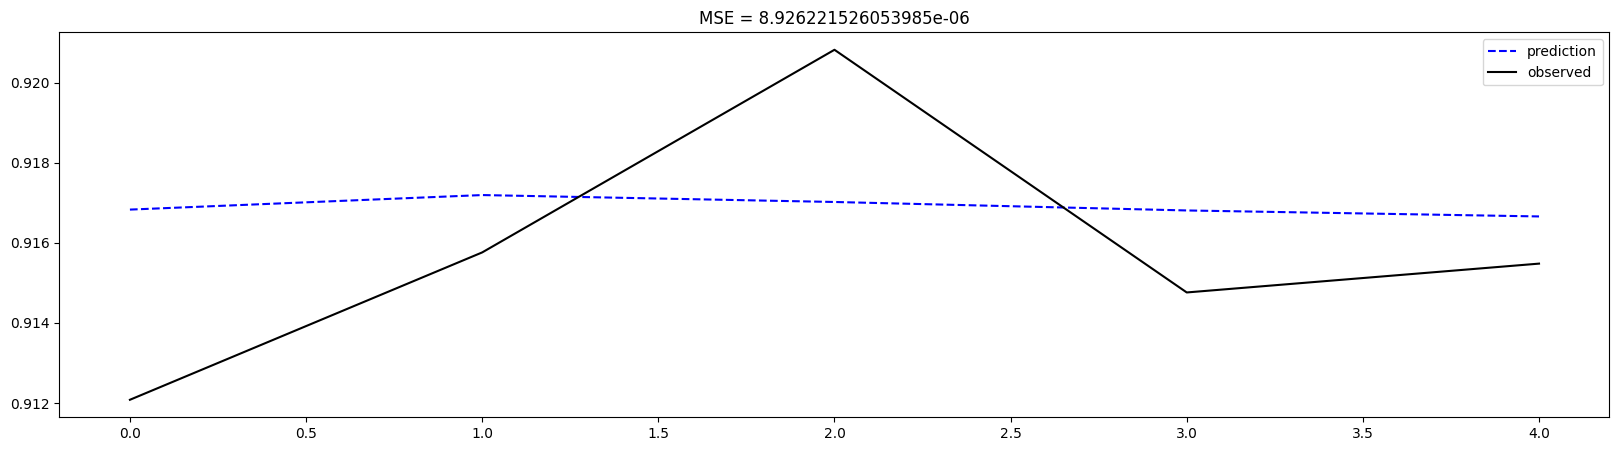

In [21]:
pred_array = plot_predictions(train_data, test, model_fit_endog)
print(pred_array)
predicted_values = pred_array['prediction']
predicted_values.to_csv('USD-CHF_endog_preds.csv', sep=',')

### Train the Model with Gold and SMI as Exogenous Variables

In [24]:
p = np.arange(5,11)
q = np.arange(5,11)
models = []
orders = []
MSEs = []
for i in p:
    for j in q:
        orders.append((i,j))
        # model = VARMAX(endog=train_set[['Close', 'SP500']], order=(i,j), exog=train_set[['Gold_USD', 'SMI']], seasonal_order=(0,0,0,0), mle_regression = True, filter_concentrated = True)
        model = VARMAX(endog=diff_train[['Close', 'SP500', 'Gold_USD']], order=(i,j), mle_regression = True, filter_concentrated = True, initialization='approximate_diffuse', exog=diff_train[['SMI']])
        model_fit = model.fit(disp=False)
        pred = pd.DataFrame()
        pred['prediction'] = train_data.iloc[-1]['Close'] + np.cumsum(model_fit.forecast(5, exog=diff_test[['Gold_USD']]).Close)
        pred['observed'] = test.Close
        models.append(model_fit)
        MSEs.append(np.mean((pred['prediction'].values-pred['observed'].values)**2))

C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['mle_regression']).Passing unknown keyword arguments will raise a TypeError beginning in versio

##### Select the most accurate model

In [ ]:
model_fit_exog = models[np.argmin(MSEs)]

#### Plot the predicted vs. the observed

   prediction  observed
0    0.962349   0.91208
1    0.936218   0.91576
2    0.913525   0.92082
3    0.889459   0.91476
4    0.864973   0.91548


C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['mle_regression']).Passing unkno

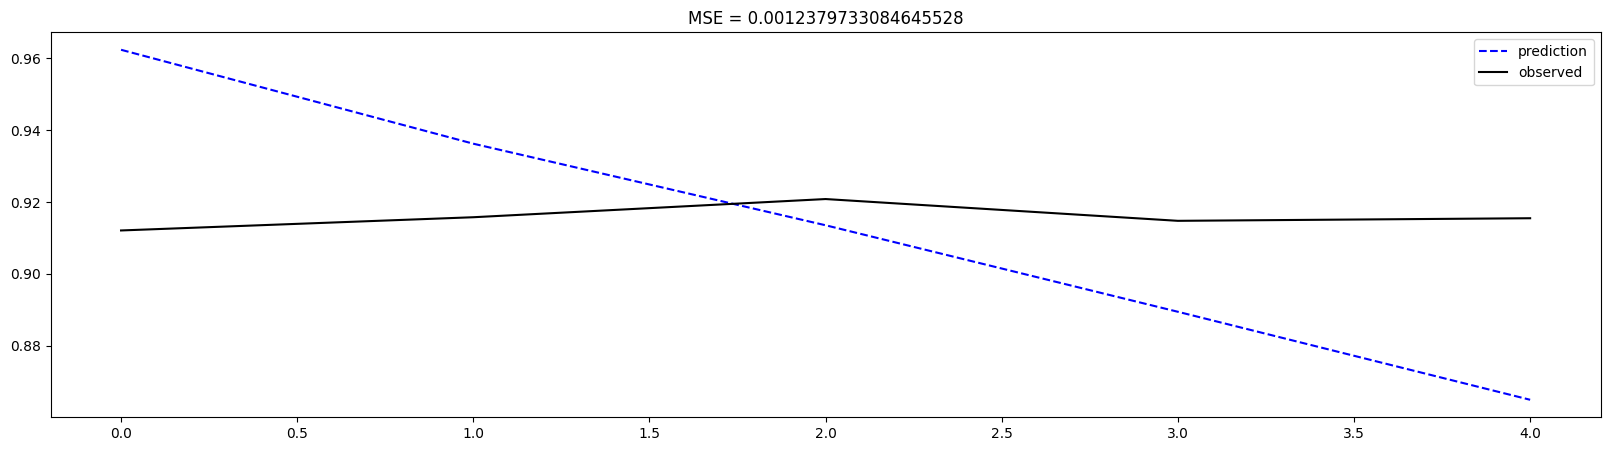

In [ ]:
exog_pred = plot_predictions(train_data, test, model_fit_exog, exog_feat=['Gold_USD'])
print(exog_pred)

#### Print the Predicted and Observed Values

In [ ]:

predicted_values = exog_pred['prediction']
predicted_values.to_csv('USDCHF_exog_preds.csv', sep=',')

### Plot after differencing removed

Text(0.5, 1.0, 'MSE = 1.5616372750899897e-05')

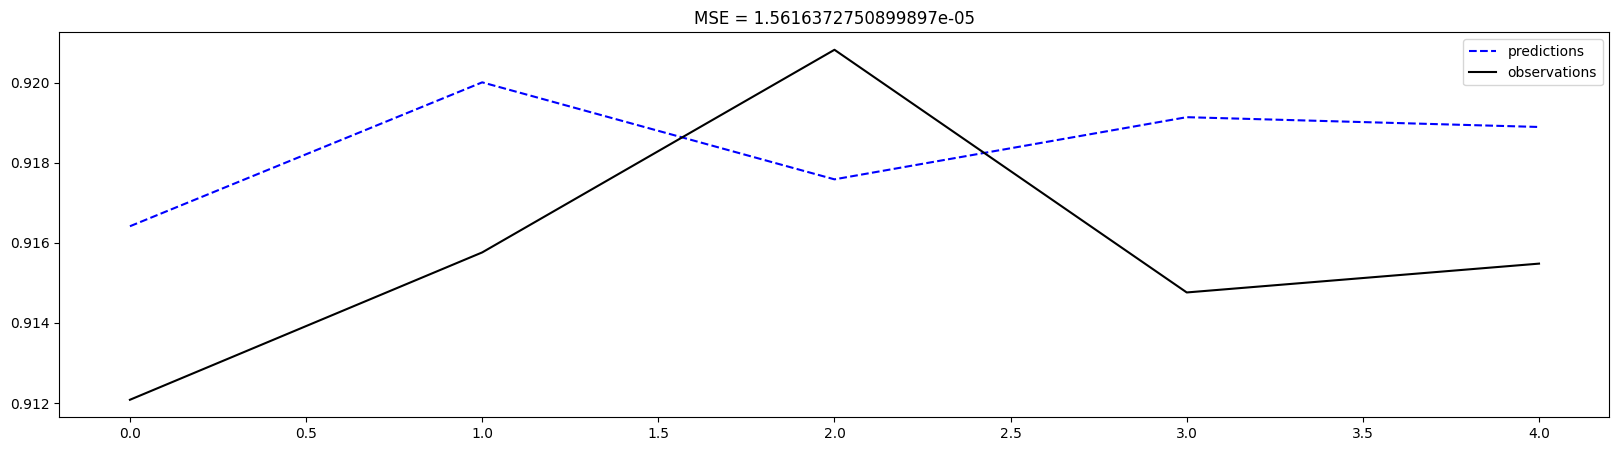

In [ ]:
# undiff_pred.plot(figsize=(20,5),title='prediction vs observed',color=['blue','black'],style=['--','-'])
# plt.title(f"MSE = {np.mean((undiff_pred['predictions'].values-undiff_pred['observations'].values)**2)}")

## Forecast predictions on the next 5, unobserved dates

### Retrain a model on the entire training set

##### Make entire differenced dataset

In [ ]:
entire_df = df.copy()
entire_diff = diff(entire_df, k_diff=1)
entire_diff = entire_diff.dropna()

In [ ]:
p = np.arange(1,6)
q = np.arange(1,6)
models = []
orders = []
MSEs = []
for i in p:
    for j in q:
        orders.append((i,j))
        model = VARMAX(entire_diff, order=(i,j), seasonal_order=(0,0,0,0), mle_regression = True, filter_concentrated = True)
        model_fit = model.fit(disp=False)
        pred = pd.DataFrame()
        pred['prediction'] = train_data.iloc[-1]['Close'] + np.cumsum(model_fit.forecast(5).reset_index(drop=True).Close)
        models.append(model_fit)
        MSEs.append(np.mean((pred['prediction'].values-pred['observed'].values)**2))